(example_4)=
# Example 4: Causal discovery in a predictive coding network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

```{admonition} Authors
:class: tip

- Lina Walkowiak, Aarhus University, Denmark ([202205493@post.au.dk](202205493@post.au.dk))
- Nicolas Legrand, Aarhus University, Denmark ([nicolas.legrand@cas.au.dk](nicolas.legrand@cas.au.dk))
```

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Callable, Dict, NamedTuple, Optional, Tuple

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import Array, jit

from pyhgf.model.network import Network
from pyhgf.typing import Edges

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Introduction

In this notebook, we are interested in embedding dynamic causal discovery in predictive coding networks. Generalised hierarchical Gaussian filters are Bayesian models. As such, they imply a portion of causality in the framework: a parent node can exert a causal influence on a child node. The strength of this causal influence is controlled by `*_couplings_*` parameters in the network's attributes.

This is in a situation where the parent is updated by the prediction errors returned by the children. But causality can also be inferred from variables that remain independent during the learning process - therefore the cause should not be updated based on a change in the effect. This corresponds to a causal discovery principle, and we can define $ \alpha_{1 \rightarrow 2} \in [0, 1]$ the *causal strength* that describes how much a variable $X_1$ is influencing another variable $X_2$. In this tutorial, we describe how this variable can be learned online.

## Data simulation

We create two synthetic time series, $x_1$ and  $x_2$, where $x_1$ influences $x_2$ with varying intensities $\alpha_{1 \rightarrow 2} \in [0, 1]$ over time. Both random variables are defined as Gaussian random walks such as: 

$$
\begin{align*} 
    X_1 & \sim \mathcal{N}(\mu_1, \sigma_1^2) \\
    X_2 & \sim \mathcal{N}(\mu_2, \sigma_2^2) \\
\end{align*} 
$$

We can explicitly inform this model that $X_1$ influences $X_2$ from one time step to the next proportionally to a coupling strength, such as:

$$
\begin{align*} 
    X_2 = \alpha X_1 + X_2 \\
\end{align*} 
$$

Were we have:

$$
\begin{align*} 
    X_2 & \sim \mathcal{N}(\alpha \mu_1 + \mu_2, \alpha^2 \sigma_1^2 + \sigma_2^2) \\
\end{align*} 
$$

We simulate below an example of a time series:

In [3]:
# Parameters
n_samples = 1000

# Generate x_1 and x_2 as a random walk
x1 = np.ones(n_samples) * 2
x2 = np.zeros(n_samples)

# Coupling vector
coupling = np.array([0.0, 0.0, 0.2, 0.2, 0.8, .8, 0.5, 0.5, 0.5, 0.5]).repeat(
    n_samples / 10
)

# Update x_2 so it is influenced by x_1 according to the coupling vector
for i in range(1, n_samples):
    x2[i] = np.random.normal(x2[i-1] + coupling[i] * x1[i-1], .1)

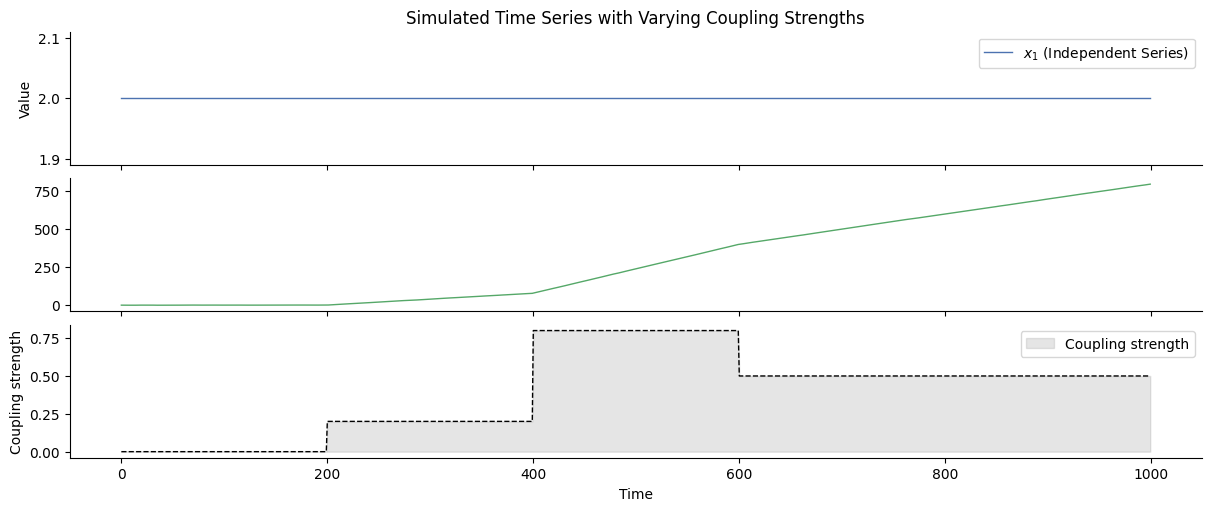

In [4]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), nrows=3, sharex=True)
axs[0].plot(x1, label=r"$x_1$ (Independent Series)", color="#4c72b0", linewidth=1)
axs[1].plot(x2, label="x2 (Dependent Series)", color="#55a868", linewidth=1)
axs[0].set(
    title="Simulated Time Series with Varying Coupling Strengths", ylabel="Value"
)
axs[0].legend()

axs[2].plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs[2].fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs[2].set(xlabel="Time", ylabel="Coupling strength")
axs[2].legend()
sns.despine();

## A non-causal network

We can filter these streams of observation using a simple one-level model without assuming dependencies between the parent nodes or the variables.

In [5]:
# Initialize two independent HGFs for X1 and X2
non_causal_hgf = (
    Network()
    .add_nodes(precision=100.0)
    .add_nodes(precision=1.0)
    .add_nodes(value_children=0, mean=2.0)
    .add_nodes(value_children=1, tonic_volatility=5.0)
)

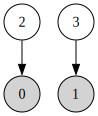

In [6]:
non_causal_hgf.plot_network()

In [7]:
# Input the time series
input_data = np.array([x1, x2]).T
non_causal_hgf.input_data(input_data=input_data);

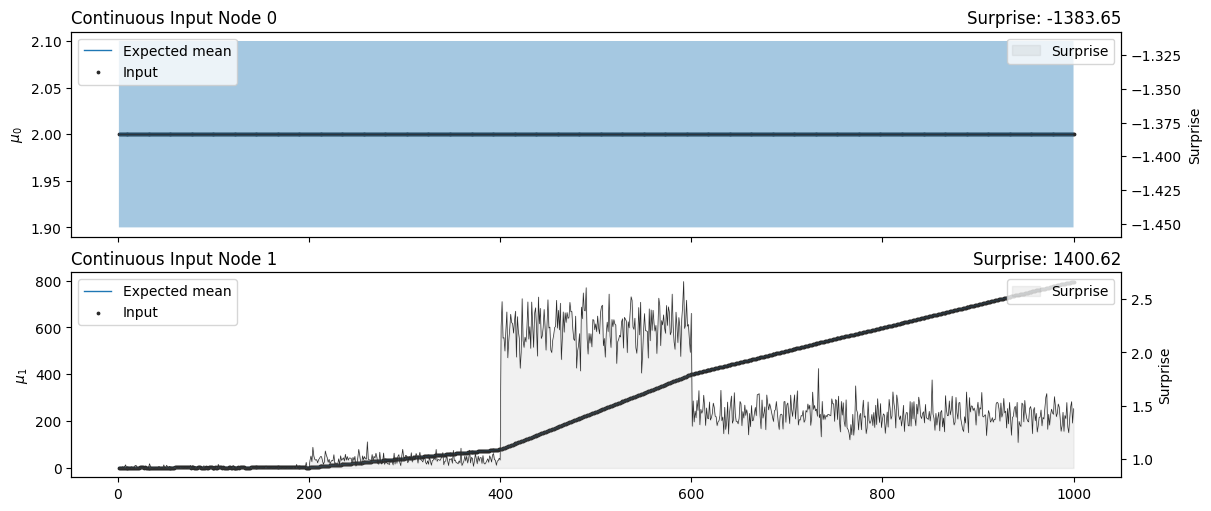

In [8]:
# Plot trajectories for each HGF
non_causal_hgf.plot_nodes(node_idxs=[0, 1]);

## Deriving prediction errors around the causal strength

We can also assume that both input nodes try to discover their causal dependencies over time by trying to contribute the the prediction of the other node and learning from their error in doing so. Given a new observation $u_1$, received by the node $1$, we can define a precision-weighted prediction errors $\delta_1$ for the non-causal hypothesis, where node $1$ only use its expectation to predict new incoming values$:

$$
\begin{align*} 
    \delta_1 & = (u - \mu_2) \cdot \frac{1}{\sigma_2^2} \\
\end{align*} 
$$

And we can also define a second prediction error $\delta_{0 \rightarrow 1}$ for the causal hypothesis, this time assuming that $X_1$ is added to $X_2$ proportionally to a coupling strength $\alpha$:

$$
\begin{align*} 
    \delta_{0 \rightarrow 1} & = (u - \mu_2 - \alpha \mu_1) \cdot \frac{1}{\alpha^2 \sigma_1^2 + \sigma_2^2} \\
\end{align*} 
$$

Let $f(\alpha)$ denote the squared precision-weigthed prediction error when assuming a given $\alpha$ as:

$$
f(\alpha) = (u - \mu_2 - \alpha \mu_1)^2 \cdot \frac{1}{\alpha^2 \sigma_1^2 + \sigma_2^2}
$$

This function has a first derivative defined as:

$$
f'(\alpha) = -\frac{2 \left({\mu}_{1} x + {\mu}_{2} - u\right) \left(\left({\mu}_{2} - y\right) {\sigma}_{1}^2 x - {\mu}_{1} {\sigma}_{2}\right)}{\left({\sigma}_{1}^2 x^{2} + {\sigma}_{2}^2\right)^{2}}
$$

Two roots can be found at:

$$
\begin{align*} 
\hat{\alpha}_1 & = -\frac{{\mu}_{2} - u}{{\mu}_{1}} \\
\\
\hat{\alpha}_2 & = \frac{{\mu}_{1} {\sigma}_{2}^2}{\left({\mu}_{2} - u\right) {\sigma}_{1}^2}
\end{align*} 
$$

It is therefore possible to recover the implied parameter $\hat{\alpha}$ over the range $[0, 1]$ by returning $\alpha \in [0.0, \hat{\alpha}_1, \hat{\alpha}_2, 1.0]$ such that $0.0 <= \alpha <= 1.0$ that minimize the precision-weigthed prediction error $f(\alpha)$.

## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of the variable $x_1$ on the variable $x_2$. This setup now implies learning the strength of a causal connection between $x_1$ and $x_2$, which should reflect the actual value used for the simulations above. We therefore use the same model as a starting point and will add an extra step in the update sequence to learn the causal coupling strength over time.

In [9]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=100.0)
    .add_nodes(precision=1.0)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1, tonic_volatility=5.0)
)

### Add a causal connection between the two nodes

In [10]:
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

In [11]:
# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

In [12]:
# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

In [13]:
# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

### Create the causal update function

Now that the variables are in place in the network, we need to create a new update function that will estimate the causal strength between the two variables at each belief propagation.

In [14]:
def prediction_error(u, alpha, mu_1, mu_2, var_1, var_2):
    return (u - mu_2 - alpha * mu_1)**2 * (1 / (alpha**2 * var_1 + var_2 ) )

In [15]:
def find_alpha(u, mu_1, mu_2, var_1, var_2):

    # find root 1
    alpha_hat_1 = jnp.where(mu_1 == 0.0, 0.0, - (mu_2 - u) / mu_1)

    # find root 2
    alpha_hat_2 = jnp.where((mu_2 - u) == 0.0, 0.0, (mu_1 * var_2) / ((mu_2 - u) * var_1))

    # evaluate at 0, 1 and the two possible roots
    candidates = jnp.array([0.0, alpha_hat_1, alpha_hat_2, 1.0])
    candidates = jnp.where((candidates >= 0.0) & (candidates <= 1.0), candidates, 0.0)

    pe = prediction_error(u, candidates, mu_1, mu_2, var_1, var_2)
    
    return candidates[jnp.argmin(pe)]

In [16]:
@partial(jit, static_argnames=("node_idx", "edges"))
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
) -> Array:
    r"""Update the causal strength between this node and all causal children.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    node_idx :
        Pointer to the value parent node that will be updated.

    Returns
    -------
    attributes :
        The attributes of the probabilistic nodes.

    """
    # get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_precision = attributes[node_idx]["expected_precision"]

    # for all causal children, compute the new causal strength
    new_strengths = []
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # get children's expected mean and precision
        child_expected_mean = attributes[causal_child_idx]["expected_mean"]
        child_expected_precision = attributes[causal_child_idx]["expected_precision"]

        # get a new estimate of alpha
        new_alpha = find_alpha(
            u=attributes[causal_child_idx]["mean"], 
            mu_1=parent_expected_mean, 
            mu_2=child_expected_mean, 
            var_1=1 / parent_expected_precision, 
            var_2=1 / child_expected_precision,
        )

        new_strengths.append(strength + (new_alpha - strength) * .05)

    # update the strengths vector
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

In [17]:
# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()

## Fitting data and visualisation

In [18]:
causal_hgf.input_data(input_data=input_data);

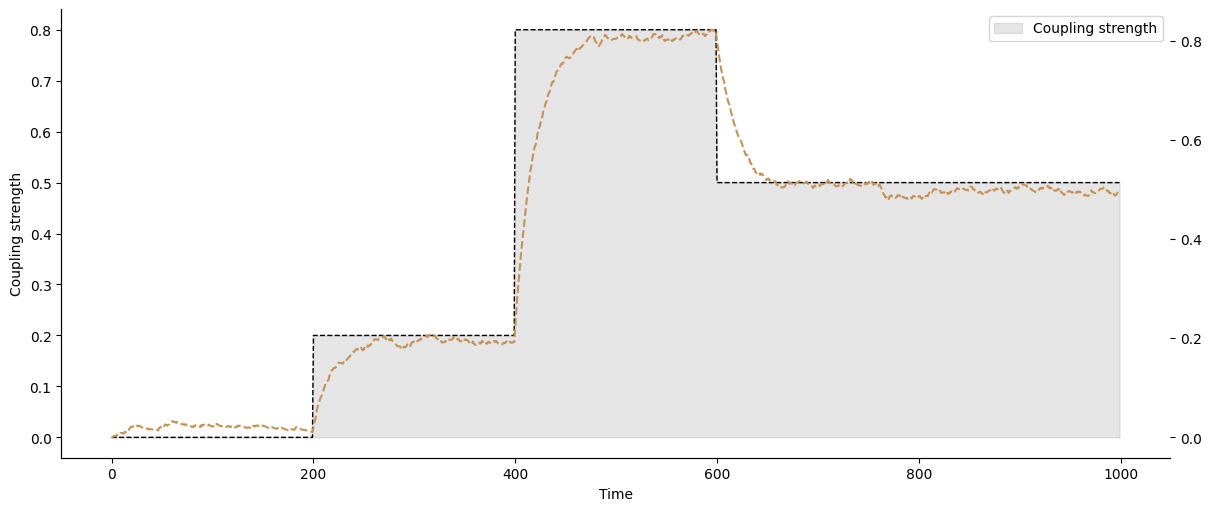

In [19]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"],
    label="Inferred coupling strength",
    color="#c69255",
    linestyle="--",
)
sns.despine();

## System configuration

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Dec 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.28.0

pyhgf : 0.2.0.post10.dev0+d35ba139
jax   : 0.4.31
jaxlib: 0.4.31

IPython   : 8.28.0
pyhgf     : 0.2.0.post10.dev0+d35ba139
seaborn   : 0.13.2
matplotlib: 3.9.2
numpy     : 1.26.0
jax       : 0.4.31
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]

Watermark: 2.5.0

